In [1]:
from collections import deque
from typing import Deque, List, Tuple

import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import pyaudio
import torch
import torchaudio

SR = 16000
plt.style.use("dark_background")

## Short-Time Fourier Transform

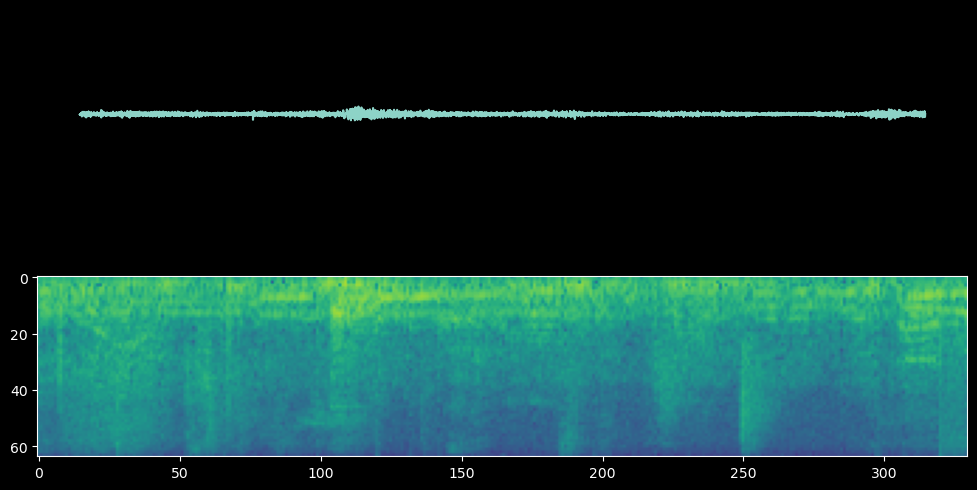

In [2]:
class SpecScaler(torch.nn.Module):
    def forward(self, spectrogram: torch.Tensor) -> torch.Tensor:
        return torch.log(spectrogram.clamp_(1e-9, 1e9))


class LowPass(torch.nn.Module):
    def __init__(self, max_freq: int = 4000, sr: int = 16000):
        super().__init__()
        self.max_freq = max_freq
        self.sr = sr

    def forward(self, waveform):
        waveform, _ = torchaudio.sox_effects.apply_effects_tensor(
            waveform, sample_rate=self.sr, effects=[["lowpass", str(self.max_freq)]]
        )
        return waveform


def create_stream(
    pyaudio_manager,
    sample_rate: int = 16_000,
    frames_per_buffer: int = 1600,
):
    return pyaudio_manager.open(
        format=pyaudio.paInt16,
        channels=1,
        rate=sample_rate,
        input=True,
        frames_per_buffer=frames_per_buffer,
    )


def record_audio(stream, duration_seconds: float = 0.1) -> np.ndarray:
    frames_to_read = int(stream._rate * duration_seconds)
    byte_frames: bytes = stream.read(frames_to_read, exception_on_overflow=False)
    audio_frame = np.frombuffer(byte_frames, dtype=np.int16)
    float_audio_frame = audio_frame / (1 << 15)
    return float_audio_frame


def record_stft_kws(
    chunks: int,
    sr: int = 16_000,
    lowpass: bool = False,
) -> Tuple[Deque, Deque]:

    frame_history: Deque = deque(maxlen=chunks)
    spec_history: Deque = deque(maxlen=chunks)

    pa_manager = pyaudio.PyAudio()
    stream = create_stream(pa_manager, sample_rate=sr)

    transforms: List[torch.nn.Module] = (
        [LowPass(max_freq=4000, sr=sr)] if lowpass else []
    )
    transforms.extend(
        [
            torchaudio.transforms.MelSpectrogram(
                sample_rate=sr,
                n_fft=400,
                win_length=400,
                hop_length=160,
                n_mels=64,
            ),
            SpecScaler(),
        ]
    )

    feature_extractor = torch.nn.Sequential(*transforms)

    while True:
        try:
            audio_frames = record_audio(stream)
            frame_history.append(audio_frames)
            data = np.concatenate(list(frame_history))
            last_data = frame_history[-1]
            last_data_tensor = (
                torch.from_numpy(last_data).unsqueeze(0).to(torch.float32)
            )
            spec_history.append(feature_extractor(last_data_tensor))
            spectrogram = torch.cat(list(spec_history), dim=2)[0].numpy()

            plt.figure(figsize=(12, 6))
            plt.subplot(211)
            plt.axis("off")
            plt.grid(False)
            plt.plot(data)
            plt.ylim(-0.5, 0.5)

            plt.subplot(212)
            plt.imshow(spectrogram, vmin=-20, vmax=4)

            plt.show()
            ipd.clear_output(wait=True)
        except (OSError, KeyboardInterrupt):
            pa_manager.terminate()
            stream.stop_stream()
            stream.close()
            break

    return frame_history, spec_history


_ = record_stft_kws(chunks=30, sr=SR, lowpass=False)

## Keyword Spotting Inference

In [3]:
import onnxruntime as ort

sess_options = ort.SessionOptions()
sess_options.intra_op_num_threads = 4
sess_options.inter_op_num_threads = 4
ort_sess = ort.InferenceSession("../kws/data/kws.onnx", sess_options=sess_options)

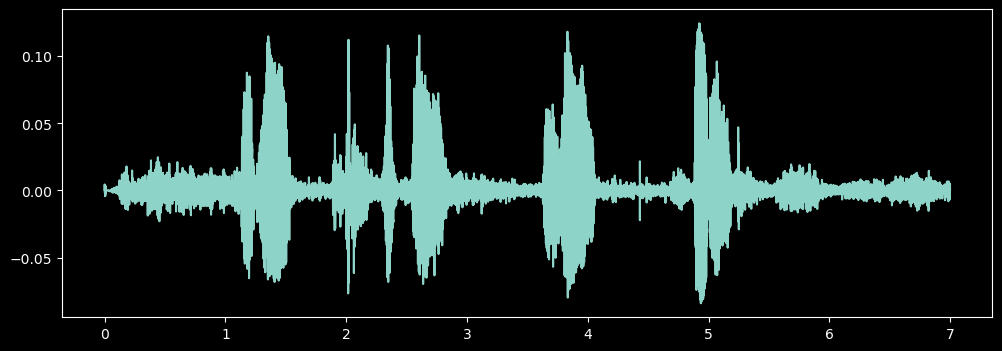

In [4]:
pa_manager = pyaudio.PyAudio()
stream = create_stream(pa_manager, sample_rate=SR)

seconds = 7
chunk_duration = 0.1
frames = []

while len(frames) < seconds / chunk_duration:
    audio_frames = record_audio(stream, duration_seconds=chunk_duration)
    frames.append(audio_frames)

waveform = np.concatenate(frames)

ipd.display(ipd.Audio(waveform, rate=SR))
plt.figure(figsize=(12, 4))
plt.plot(np.arange(waveform.size) / SR, waveform)
plt.show()

In [5]:
feature_extractor = torch.nn.Sequential(
    torchaudio.transforms.MelSpectrogram(
        sample_rate=SR,
        n_fft=400,
        win_length=400,
        hop_length=160,
        n_mels=64,
    ),
    SpecScaler(),
)

start = 0
shift = SR // 10

probs = []

while start <= waveform.size - SR:
    audio_chunk = waveform[start : start + SR]
    audio_tensor = torch.from_numpy(audio_chunk).unsqueeze(0).to(torch.float32)
    features = feature_extractor(audio_tensor)
    ort_features = features.numpy()

    logprobs, _ = ort_sess.run(None, {"features": ort_features})

    probs.append(np.exp(logprobs))

    start += shift

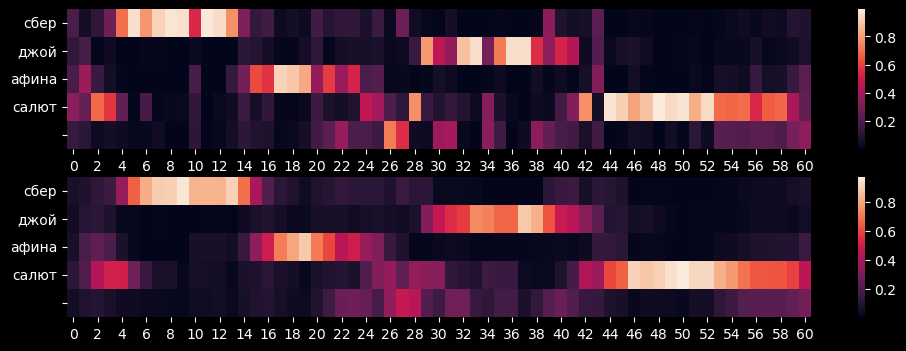

In [6]:
import seaborn as sns

classes = ["сбер", "джой", "афина", "салют", ""]

window_size = 3
window_filter = np.ones(window_size) / window_size

prob_matrix = np.vstack(probs).T
smoothed_prob_matrix = np.array(
    [
        np.convolve(
            np.pad(row, pad_width=(window_size - 1, 0), constant_values=(0,)),
            window_filter,
            mode="valid",
        )
        for row in prob_matrix
    ]
)

plt.figure(figsize=(12, 4))
plt.subplot(211)
sns.heatmap(
    prob_matrix,
    yticklabels=classes,
)
plt.subplot(212)
sns.heatmap(
    smoothed_prob_matrix,
    yticklabels=classes,
)
plt.show()